<a href="https://colab.research.google.com/github/juhumkwon/Data/blob/main/U_Net(Pet_Image_SegmentationPet_Image_Segmentation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import pandas as pd
import random
from tensorflow.keras.utils import array_to_img
from PIL import Image
import cv2

import warnings
warnings.filterwarnings("ignore")

In [30]:
from google.colab import drive

# Google Drive 마운트
drive.mount('/content/drive')

import os
""""
file_path = '/content/drive/My Drive/MyDataset/images.tar.gz'
if os.path.exists(file_path):
    print(f"파일이 존재합니다: {file_path}")
else:
    print(f"파일이 존재하지 않습니다: {file_path}")
"""

#!tar -xf '/content/drive/My Drive/MyDataset/images.tar.gz' -C '/content/drive/My Drive/MyDataset/images'
!tar -xf '/content/drive/My Drive/MyDataset/annotations.tar.gz' -C '/content/drive/My Drive/MyDataset/annotations'

input_dir = "images/"
target_dir = "annotations/trimaps/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
input_img_paths = sorted([os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith(".jpg")])
target_img_paths = sorted([os.path.join(target_dir, fname) for fname in os.listdir(target_dir) if fname.endswith(".png") and not fname.startswith(".")])

print(len(input_img_paths))
print(len(target_img_paths))

7390
7390


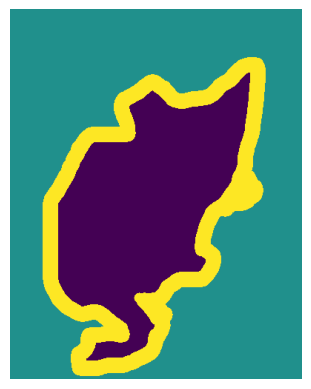

In [33]:
load_img(input_img_paths[2])
def display_target(img):
    normalized_img = (img.astype("uint8") - 1) * 127 # 0-255
    plt.axis("off")
    plt.imshow(normalized_img[:, :, 0])

img = load_img(target_img_paths[2], color_mode='grayscale')
img = img_to_array(img)
display_target(img)

In [34]:
img_size = (256, 256)  # Increased image size for better resolution

def path_to_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = tf.cast(img, tf.float32) / 255.0  # Normalize to [0, 1]
    return img

def path_to_target(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=1)
    img = tf.image.resize(img, img_size)
    img = tf.cast(img, tf.uint8) - 1
    return img

def map_fn(img_path, target_path):
    img = path_to_img(img_path)
    mask = path_to_target(target_path)
    return img, mask

In [35]:
def augment_data(image, mask):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image, mask

In [42]:
import tensorflow as tf

def prepare_dataset(image_paths, mask_paths, batch_size, should_augment=False):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))

    # Apply map_fn directly without tf.py_function
    dataset = dataset.map(map_fn, num_parallel_calls=tf.data.AUTOTUNE)

    # Set the output shapes explicitly
    # dataset = dataset.map(lambda img, mask: (tf.ensure_shape(img, img_size + (3,)), tf.ensure_shape(mask, img_size + (1,))),
    #                       num_parallel_calls=tf.data.AUTOTUNE)

    # Set output types and shapes for better compatibility
    dataset = dataset.map(lambda img, mask: (tf.ensure_shape(img, img_size + (3,)), tf.ensure_shape(mask, img_size + (1,))),
                          num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(lambda img, mask: (tf.cast(img, tf.float32), tf.cast(mask, tf.uint8)),
                          num_parallel_calls=tf.data.AUTOTUNE)

    if should_augment:
        dataset = dataset.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)

    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [43]:
def unet_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    # Encoder (Downsampling)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bridge
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # Decoder (Upsampling)
    up5 = layers.UpSampling2D(size=(2, 2))(conv4)
    up5 = layers.concatenate([up5, conv3])
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = layers.UpSampling2D(size=(2, 2))(conv5)
    up6 = layers.concatenate([up6, conv2])
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = layers.UpSampling2D(size=(2, 2))(conv6)
    up7 = layers.concatenate([up7, conv1])
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv7)

    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(conv7)

    model = Model(inputs=inputs, outputs=outputs)

    return model

num_classes = 3
# model = unet_model(img_size,img_size[0], num_classes)
model = unet_model(img_size, num_classes)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_63 (Conv2D)        │ (None, 256, 256, 64)   │          1,792 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_64 (Conv2D)        │ (None, 256, 256, 64)   │         36,928 │ conv2d_63[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 128, 128, 64)   │              0 │ conv2d_64[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_65 (Conv2D)        │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_66 (Conv2D)        │ (None, 128, 128, 128)  │        147,584 │ conv2d_65[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_13          │ (None, 64, 64, 128)    │              0 │ conv2d_66[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_67 (Conv2D)        │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_13[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_68 (Conv2D)        │ (None, 64, 64, 256)    │        590,080 │ conv2d_67[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_14          │ (None, 32, 32, 256)    │              0 │ conv2d_68[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_69 (Conv2D)        │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_14[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_70 (Conv2D)        │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_69[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_12          │ (None, 64, 64, 512)    │              0 │ conv2d_70[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_12            │ (None, 64, 64, 768)    │              0 │ up_sampling2d_12[0][0… │
│ (Concatenate)             │                        │                │ conv2d_68[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_71 (Conv2D)        │ (None, 64, 64, 256)    │      1,769,728 │ concatenate_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_72 (Conv2D)        │ (None, 64, 64, 256)    │        590,080 │ conv2d_71[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_13     

 Total params: 7,783,043 (29.69 MB)

 Trainable params: 7,783,043 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
initial_learning_rate = 1e-4

optimizer = keras.optimizers.Adam(learning_rate=initial_learning_rate)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation_unet.keras", save_best_only=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                      factor=0.5,
                                      patience=5,
                                      min_lr=1e-6,
                                      verbose=1),
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
]

history = model.fit(train_dataset,
                    epochs=60,
                    callbacks=callbacks,
                    validation_data=valid_dataset)

Epoch 1/60


NotFoundError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/tornado/ioloop.py", line 699, in <lambda>

  File "/usr/local/lib/python3.11/dist-packages/tornado/ioloop.py", line 750, in _run_callback

  File "/usr/local/lib/python3.11/dist-packages/tornado/gen.py", line 824, in inner

  File "/usr/local/lib/python3.11/dist-packages/tornado/gen.py", line 785, in run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.11/dist-packages/tornado/gen.py", line 233, in wrapper

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/tornado/gen.py", line 233, in wrapper

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/tornado/gen.py", line 233, in wrapper

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-49-0df68aafbdcf>", line 19, in <cell line: 0>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

could not find registered transfer manager for platform Host -- check target linkage
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_multi_step_on_iterator_48561]

NameError: name 'history' is not defined

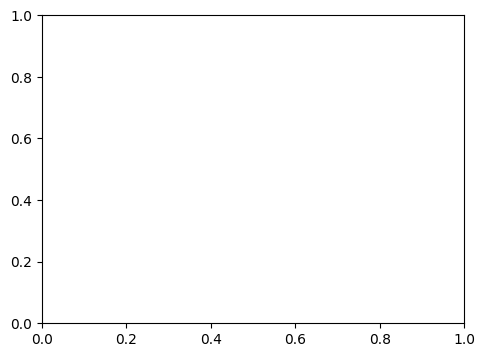

In [50]:
# Plotting training history
plt.figure(figsize=(12,4))
plt.subplot(1 , 2 ,1 )
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1 , 2 ,2 )
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()